In [1]:
import pandas as pd

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm

import pyfolio as pf

import quantstats as qs

import empyrical as ep

from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

C:\Users\Alienware\miniconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


The effect of diversification

In this exercise you're going to compare performance of four individual stocks, to a portfolio of the same four stocks. You'll see that 2 out of the four stocks will under-perform over a time period of roughly four years, and two will perform quite well.

The stocks you're going to investigate are General Electric, JP Morgan, Microsoft and Proctor & Gamble.

Let's play a little game: pick one stock to invest in, then, let's see how it would have performed over time. There's a 50-50 chance that you'll pick a winning stock, versus a losing stock. Let's look at the data and see whether your stock is one of strong performers.

Available is a data set called stock_returns containing the cumulative returns of these four stocks over time, plus a portfolio of these stocks.

In [2]:
small_portfolio = pd.read_csv('small_portfolio.csv', index_col=0)
small_portfolio

,GE,JPM,MSFT,PG
date,,,,
2015-01-02,25.06,62.49,46.760,90.44
2015-01-05,24.60,60.55,46.325,90.01
2015-01-06,24.07,58.98,45.650,89.60
2015-01-07,24.08,59.07,46.230,90.07
2015-01-08,24.37,60.39,47.590,91.10
...,...,...,...,...
2018-03-21,13.88,114.74,92.480,77.04
2018-03-22,13.35,109.95,89.790,76.41
2018-03-23,13.07,107.01,87.180,75.91


In [3]:
stock_returns = small_portfolio/small_portfolio.iloc[0]
stock_returns['portfolio'] = stock_returns.mean(axis=1) 
# all the weights of the stocks in the portfolio are equal, hence we are looking at an equal weighted portfolio.
stock_returns

,GE,JPM,MSFT,PG,portfolio
date,,,,,
2015-01-02,1.000000,1.000000,1.000000,1.000000,1.000000
2015-01-05,0.981644,0.968955,0.990697,0.995245,0.984135
2015-01-06,0.960495,0.943831,0.976262,0.990712,0.967825
2015-01-07,0.960894,0.945271,0.988666,0.995909,0.972685
2015-01-08,0.972466,0.966395,1.017750,1.007298,0.990977
...,...,...,...,...,...
2018-03-21,0.553871,1.836134,1.977759,0.851835,1.304900
2018-03-22,0.532721,1.759482,1.920231,0.844870,1.264326
2018-03-23,0.521548,1.712434,1.864414,0.839341,1.234434


In [4]:
def plot_pct_returns(df):
    fig, ax = plt.subplots()
    ax.plot(df.index, df.MSFT, marker='', color='green', linewidth=2, label="MSFT")
    ax.plot(df.index, df.portfolio, linewidth=2, linestyle='dashed', color='skyblue', label='portfolio')
    ax.plot(df.index, df.PG, marker='', color='pink', linewidth=2, label="PG")
    ax.plot(df.index, df.JPM, color='yellow', linewidth=2, label='JPM')
    ax.plot(df.index, df.GE, color='red', linewidth=2, label='GE')
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
    #ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator((1,4,7,10)))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("\n%Y"))
    #ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter("%b"))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    plt.legend()
    plt.show()

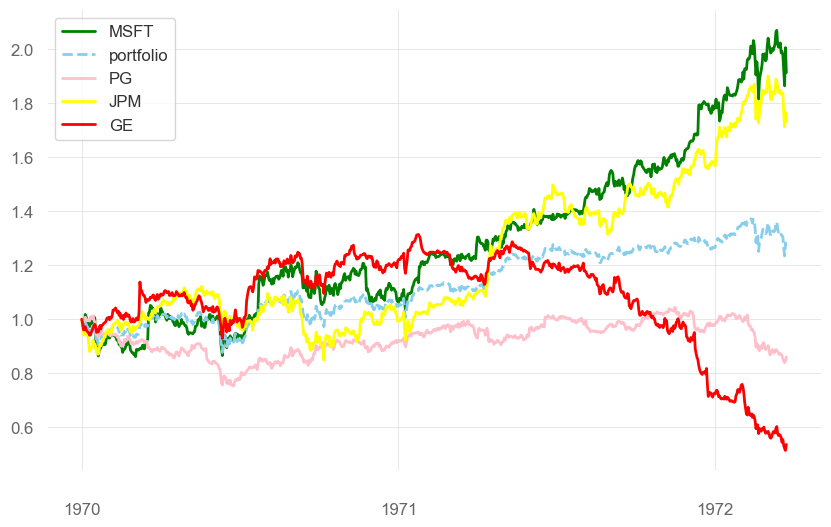

In [5]:
plot_pct_returns(stock_returns)

Calculate mean returns

In this exercise, you're going to calculate performance for a four stock portfolio over the period January 2015 through March 2019. The portfolio consists of Proctor & Gamble, Microsoft, JP Morgan and General Electric stocks. You'll discover that multiplying the mean return of each stock with its portfolio weight, is a very quick and straightforward way to calculate portfolio performance over a given period of time.

In [6]:
# Calculate percentage returns
returns = small_portfolio.pct_change()
returns

,GE,JPM,MSFT,PG
date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.018356,-0.031045,-0.009303,-0.004755
2015-01-06,-0.021545,-0.025929,-0.014571,-0.004555
2015-01-07,0.000415,0.001526,0.012705,0.005246
2015-01-08,0.012043,0.022346,0.029418,0.011436
...,...,...,...,...
2018-03-21,0.017595,0.000872,-0.006979,-0.016218
2018-03-22,-0.038184,-0.041747,-0.029087,-0.008178
2018-03-23,-0.020974,-0.026739,-0.029068,-0.006544


In [7]:
# Calculate individual mean returns 
meanDailyReturns = returns.mean()
meanDailyReturns

GE     -0.000675
JPM     0.000769
MSFT    0.000907
PG     -0.000144
dtype: float64

In [8]:
# Define weights for the portfolio
weights = np.array([0.5, 0.2, 0.2, 0.1])

# Calculate expected portfolio performance
portReturn = np.sum(meanDailyReturns*weights)

portReturn

-1.6782226618545438e-05

Portfolio cumulative returns

In the previous exercise, you've calculated the mean performance over a period of time. This gives you one performance number for that entire period. But what if you would want to plot the development of the performance over time? For that, you will need the cumulative performance, not the mean performance. Just like with interest in your bank account, the cumulative performance gives you the compounded return at each date in your dataset. It tells you; "up until today, this is what the total return has been since the start of my data."

Remember because of the compounding effect, you need to use cumprod() for this calculation.

In [9]:
# Create portfolio returns column
returns['Portfolio']= returns.dot(weights)
# The 'Portfolio' column represents the total return of the portfolio for each corresponding time period, 
# taking into account the weights of the individual assets.
returns

,GE,JPM,MSFT,PG,Portfolio
date,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.018356,-0.031045,-0.009303,-0.004755,-0.017723
2015-01-06,-0.021545,-0.025929,-0.014571,-0.004555,-0.019328
2015-01-07,0.000415,0.001526,0.012705,0.005246,0.003579
2015-01-08,0.012043,0.022346,0.029418,0.011436,0.017518
...,...,...,...,...,...
2018-03-21,0.017595,0.000872,-0.006979,-0.016218,0.005954
2018-03-22,-0.038184,-0.041747,-0.029087,-0.008178,-0.034077
2018-03-23,-0.020974,-0.026739,-0.029068,-0.006544,-0.022303


In [10]:
# Calculate cumulative returns, to determine the cumulative return over time, accounting for the compounding effect of returns

daily_cum_ret=(1 + returns).cumprod()
# Adding 1 to each return value effectively converts the daily return percentages into factors. 
# For example, a daily return of 5% (0.05) becomes 1.05, representing a 5% increase.
# The cumprod() function computes the cumulative product of the elements along the specified axis (default is axis=0, i.e., row-wise). 
# This means it multiplies the current value by all previous values in the series.

daily_cum_ret

,GE,JPM,MSFT,PG,Portfolio
date,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN
2015-01-05,0.981644,0.968955,0.990697,0.995245,0.982277
2015-01-06,0.960495,0.943831,0.976262,0.990712,0.963292
2015-01-07,0.960894,0.945271,0.988666,0.995909,0.966739
2015-01-08,0.972466,0.966395,1.017750,1.007298,0.983674
...,...,...,...,...,...
2018-03-21,0.553871,1.836134,1.977759,0.851835,0.974287
2018-03-22,0.532721,1.759482,1.920231,0.844870,0.941086
2018-03-23,0.521548,1.712434,1.864414,0.839341,0.920097


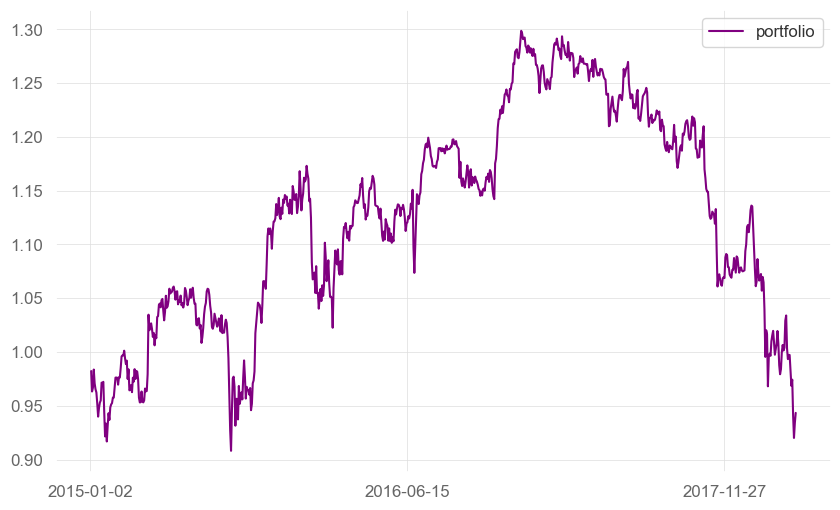

In [11]:
# Plot the portfolio cumulative returns only
fig, ax = plt.subplots()
ax.plot(daily_cum_ret.index, daily_cum_ret.Portfolio, color='purple', label="portfolio")
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
plt.legend()
plt.show()

Portfolio variance

It's time to calculate the risk of our 4-stock portfolio. Let's start with the pricing data, available under data. You'll have to calculate daily percentage returns and assign weights to your portfolio. You'll then continue by calculating the covariance matrix, and use the following formula: Portfolio variance = Weights transposed x (Covariance matrix x Weights) to get the final portfolio variance.

As calculating portfolio variance is an important part of portfolio analysis

In [12]:
returns.drop('Portfolio', axis=1, inplace=True)
returns

,GE,JPM,MSFT,PG
date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.018356,-0.031045,-0.009303,-0.004755
2015-01-06,-0.021545,-0.025929,-0.014571,-0.004555
2015-01-07,0.000415,0.001526,0.012705,0.005246
2015-01-08,0.012043,0.022346,0.029418,0.011436
...,...,...,...,...
2018-03-21,0.017595,0.000872,-0.006979,-0.016218
2018-03-22,-0.038184,-0.041747,-0.029087,-0.008178
2018-03-23,-0.020974,-0.026739,-0.029068,-0.006544


In [13]:
# Assign portfolio weights
weights = np.array([0.05, 0.4, 0.3, 0.25])

# Calculate the covariance matrix 
cov_matrix = (returns.cov())*250

cov_matrix

,GE,JPM,MSFT,PG
GE,0.045987,0.022828,0.016285,0.010101
JPM,0.022828,0.046660,0.024135,0.010812
MSFT,0.016285,0.024135,0.054054,0.014144
PG,0.010101,0.010812,0.014144,0.020645


In [14]:
# Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix, weights))

# Print the result
print(str(np.round(port_variance, 4) * 100) + '%')

2.55%


Standard deviation versus variance

the standard deviation  is simply the square root of the variance. Both measures are used in practice to calculate market or stock volatility. Why should you use one or the other?

In the variance calculation we square the weights and the variances. Because of this squaring, the variance is no longer in the same unit of measurement as the original data. Taking the root of the variance means the standard deviation is restored to the original unit of measure and therefore much easier to interpret.

In [15]:
# Calculate the standard deviation by taking the square root
port_standard_dev = np.sqrt(port_variance)

# Print the results 
print(str(np.round(port_standard_dev, 4) * 100) + '%')

# The standard deviation tells you how much the portfolio's return can deviate from the mean historical return. 
# If a portfolio has a 12% average rate of return and a standard deviation of 4%, its return will range from 8-16%. 
# The mean historic return of this particular portfolio is actually close to zero. 
# With an average standard deviation of roughly 16%, this means you're getting a bad deal here! 

15.959999999999999%


Annualizing portfolio returns

Suppose you invested $101 at the beginning of 2015 in a portfolio. By the end of March 2018, you wonder how your portfolio has performed over time, and whether it is as good as another portfolio which started trading mid-2016. What performance metric do you look at? Well, the annualized return of course!

So let's calculate the annualized rate of return for your portfolio. Since our sample covers 3.2 years, let's use the monthly denomination in the formula for annualized returns. 

In [16]:
pf_AUM = pd.read_csv('pf_AUM.csv')
pf_AUM['AUM'] = pf_AUM['Unnamed: 1'].combine_first(pf_AUM['Unnamed: 2'])
pf_AUM.drop(['Unnamed: 1','Unnamed: 2'], axis=1, inplace=True)
pf_AUM

,date,AUM
0,02/01/2015,101.000
1,05/01/2015,99.667
2,06/01/2015,98.088
3,07/01/2015,99.042
4,08/01/2015,101.638
...,...,...
808,21/03/2018,184.188
809,22/03/2018,178.749
810,23/03/2018,174.039
811,26/03/2018,184.450


In [17]:
pf_AUM['Returns'] = pf_AUM['AUM'].pct_change()
pf_AUM

,date,AUM,Returns
0,02/01/2015,101.000,NaN
1,05/01/2015,99.667,-0.013198
2,06/01/2015,98.088,-0.015843
3,07/01/2015,99.042,0.009726
4,08/01/2015,101.638,0.026211
...,...,...,...
808,21/03/2018,184.188,-0.006328
809,22/03/2018,178.749,-0.029530
810,23/03/2018,174.039,-0.026350
811,26/03/2018,184.450,0.059820


In [18]:
# Calculate total rate of return from portfolio AUM
aum_total_return = (pf_AUM.AUM.iloc[-1] - pf_AUM.AUM.iloc[1]) / pf_AUM.AUM.iloc[1]
aum_total_return

0.7872816478874654

In [19]:
months = 38

# Annualize return over 3.2 years (38 months)
aum_annualized_return = ((1 + aum_total_return)**(12/months)) - 1
aum_annualized_return

0.2012679590641493

Comparing annualized rates of return

In the last exercise, you saw that the annualized rate of return was 20%. That's pretty high! But since your portfolio consists of only 4 stocks, this high return is indeed possible as it is not very diversified. Let's compare the portfolio's annual rate of return, with that of the S&P500, which is much more diversified.

The value of the S&P500 between 1st of January 2015 and end of December 2018 has been made available. That's 4 years of data. You have full years this time, so use the year denomination in the formula for the annualized return. 

In [20]:
sp500 = pd.read_csv('sp500.csv')
sp500['Returns'] = sp500['S&P500'].pct_change()
sp500

,date,S&P500,Returns
0,2015-01-02,2058.199951,NaN
1,2015-01-05,2020.579956,-0.018278
2,2015-01-06,2002.609985,-0.008893
3,2015-01-07,2025.900024,0.011630
4,2015-01-08,2062.139893,0.017888
...,...,...,...
1054,2019-03-13,2810.919922,0.006950
1055,2019-03-14,2808.479980,-0.000868
1056,2019-03-15,2822.479980,0.004985
1057,2019-03-18,2832.939941,0.003706


In [21]:
# Calculate the total return from the S&P500 value series
sp_total_return = (sp500['S&P500'].iloc[-1] - sp500['S&P500'].iloc[0]) / sp500['S&P500'].iloc[0]
sp_total_return

0.3762365831481841

In [22]:
# Annualize the total return spanning 4 years
sp_annualized_return = ((1 + sp_total_return)**(1/4))-1
sp_annualized_return

0.08311176814071208

S&P500 Sharpe ratio

In this exercise, you're going to calculate the Sharpe ratio of the S&P500, starting with pricing data only. In the next exercise, you'll do the same for the portfolio data, such that you can compare the Sharpe ratios of the two.

In [23]:
# Calculate annualized volatility from the standard deviation
vol_sp500 = sp500['Returns'].std() * np.sqrt(252)
vol_sp500

0.1366798064443735

In [24]:
rfr = 0 # assuming zero risk free rate

# Calculate the Sharpe ratio 
sp_sharpe_ratio = ((sp_annualized_return - rfr) / vol_sp500) 
sp_sharpe_ratio

0.6080764254998945

Portfolio Sharpe ratio

In this exercise you are now going to calculate the Sharpe ratio of the portfolio. How do you think the portfolio Sharpe ratio will be different to the S&P500 Sharpe ratio? 

In [25]:
# Calculate annualized volatility from the standard deviation
vol_pf = pf_AUM['Returns'].std()*np.sqrt(250)
vol_pf


0.19424284189903393

In [26]:
# Calculate the Sharpe ratio 
aum_sharpe_ratio = ((aum_annualized_return - rfr) /vol_pf)
aum_sharpe_ratio

1.0361666720710716

Skewness of the S&P500

We already know from the video that the S&P500 should be normally distributed, without too much skewness (when you have enough data). However, since you're working with a short data sample spanning only a few years, there might actually be some skewness in your sample. To make you aware of this potential sample skewness, let's plot the data and have a look.

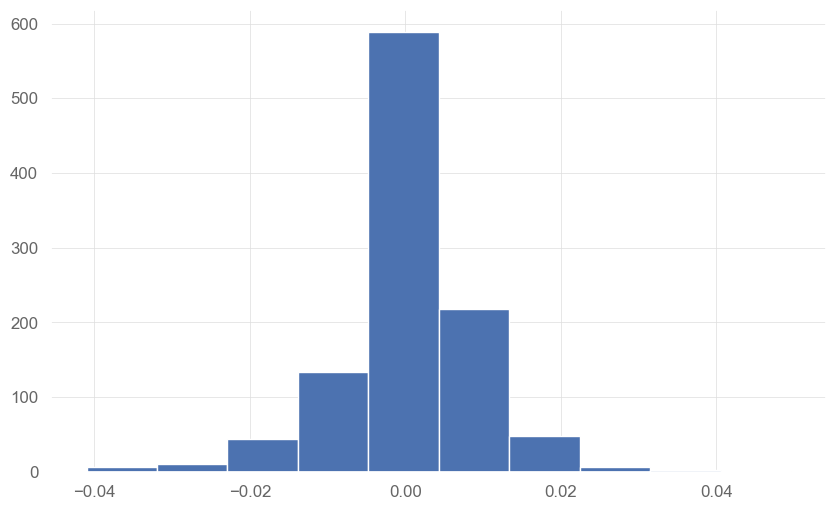

In [27]:
# Create a histogram of the S&P500 returns and show the plot
sp500['Returns'].hist()
plt.show()

Calculating skewness and kurtosis

You just saw the histogram of the S&P500 data, let's now put it into numbers and calculate skewness and kurtosis. For the full picture of the distribution, you'll also look at the mean and standard deviation. Available are the S&P500 returns data under returns_sp500, which is all you need for this.

In [28]:
# Print the mean
print("mean : ", sp500['Returns'].mean()*100)

# Print the mean
print("median : ", sp500['Returns'].median()*100)

# Print the standard deviation
print("Std. dev  : ", sp500['Returns'].std()*100)

# Print the skewness
print("skew : ", sp500['Returns'].skew())

# Print the kurtosis
print("kurt : ", sp500['Returns'].kurtosis())

mean :  0.03389998442910263
median :  0.03700511683232266
Std. dev  :  0.8610018502291801
skew :  -0.3831994518762794
kurt :  3.9223911008585053


Comparing distributions of stock returns

Let's have a look at how you can use skewness and kurtosis in your investment decisions. In this exercise you're going to compare the distributions of singular stocks with the portfolio, and see whether combining multiple stocks in a portfolio improves your returns distribution.

In [29]:
# Print skewness and kurtosis of the stocks
print ("skew : ", stock_returns.skew())

skew :  GE          -1.315660
JPM          0.743794
MSFT         0.755347
PG          -0.496022
portfolio    0.066669
dtype: float64


In [30]:
print ("kurt : ", stock_returns.kurtosis())

kurt :  GE           1.071946
JPM         -0.641370
MSFT        -0.315214
PG          -0.226965
portfolio   -1.349232
dtype: float64


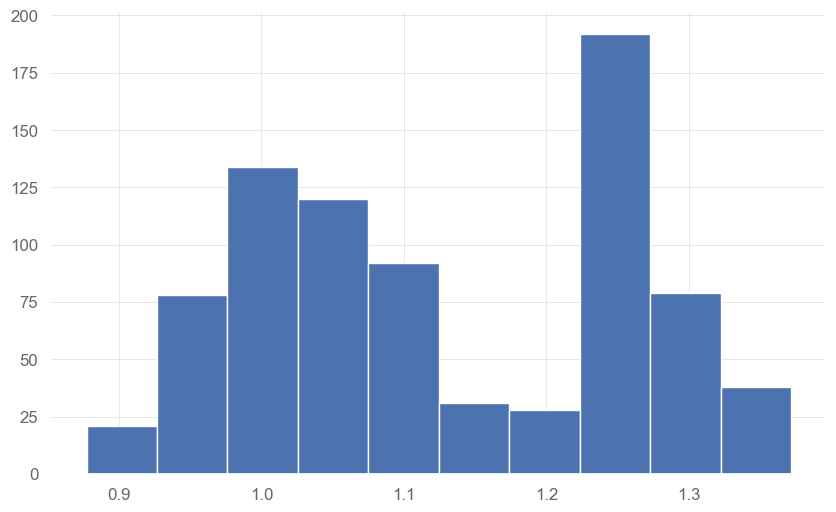

In [31]:
# Print the histogram of the portfolio
stock_returns.portfolio.hist()
plt.show()

Sortino ratio

For this exercise, calculate the Sortino ratio. The Sortino ratio is just like the Sharpe ratio, except for that it uses the standard deviation of the negative returns only, and thereby focuses more on the downside of investing.

Let's see how big the Sortino ratio is compared to the earlier calculated Sharpe ratio. 

The risk-free rate rfrand the target return target are already defined and are both zero.

In [32]:
target = 0

# Create a downside return column with the negative returns only
downside_returns = pf_AUM.loc[pf_AUM['Returns'] < target]
downside_returns

,date,AUM,Returns
1,05/01/2015,99.667,-0.013198
2,06/01/2015,98.088,-0.015843
5,09/01/2015,100.591,-0.010301
6,12/01/2015,99.501,-0.010836
7,13/01/2015,99.180,-0.003226
...,...,...,...
806,19/03/2018,185.074,-0.014620
808,21/03/2018,184.188,-0.006328
809,22/03/2018,178.749,-0.029530
810,23/03/2018,174.039,-0.026350


In [33]:
# Calculate expected return and std dev of downside
expected_return = pf_AUM['Returns'].mean()
expected_return

0.0007742338381612281

In [34]:
down_stdev = downside_returns['Returns'].std()
down_stdev

0.00890924691807902

In [35]:
# Calculate the sortino ratio
sortino_ratio = (expected_return - rfr) / down_stdev

# Print the results
print("Expected return  : ", expected_return*100)
print("Downside risk   : ", down_stdev*100)
print("Sortino ratio : ", sortino_ratio)

Expected return  :  0.0774233838161228
Downside risk   :  0.890924691807902
Sortino ratio :  0.08690227639668624


Maximum draw-down portfolio

In this exercise, you'll learn how to calculate the maximum draw-down of the S&P500 (also known as "peak to trough performance drop"). Maximum draw-down is an incredibly insightful risk measure. It tells you what has been the worst performance of the S&P500 in the past years.

In [36]:
# Calculate the max value 
roll_max = sp500['S&P500'].rolling(center=False,min_periods=1,window=252).max()
roll_max

0       2058.199951
1       2058.199951
2       2058.199951
3       2058.199951
4       2062.139893
           ...     
1054    2930.750000
1055    2930.750000
1056    2930.750000
1057    2930.750000
1058    2930.750000
Name: S&P500, Length: 1059, dtype: float64

In [37]:
# Calculate the daily draw-down relative to the max
daily_draw_down = sp500['S&P500'] / roll_max - 1
daily_draw_down

0       0.000000
1      -0.018278
2      -0.027009
3      -0.015693
4       0.000000
          ...   
1054   -0.040887
1055   -0.041720
1056   -0.036943
1057   -0.033374
1058   -0.033500
Name: S&P500, Length: 1059, dtype: float64

In [38]:
# Calculate the minimum (negative) daily draw-down
max_daily_draw_down = daily_draw_down.rolling(center=False,min_periods=1,window=252).min()
max_daily_draw_down

0       0.000000
1      -0.018278
2      -0.027009
3      -0.027009
4      -0.027009
          ...   
1054   -0.197782
1055   -0.197782
1056   -0.197782
1057   -0.197782
1058   -0.197782
Name: S&P500, Length: 1059, dtype: float64

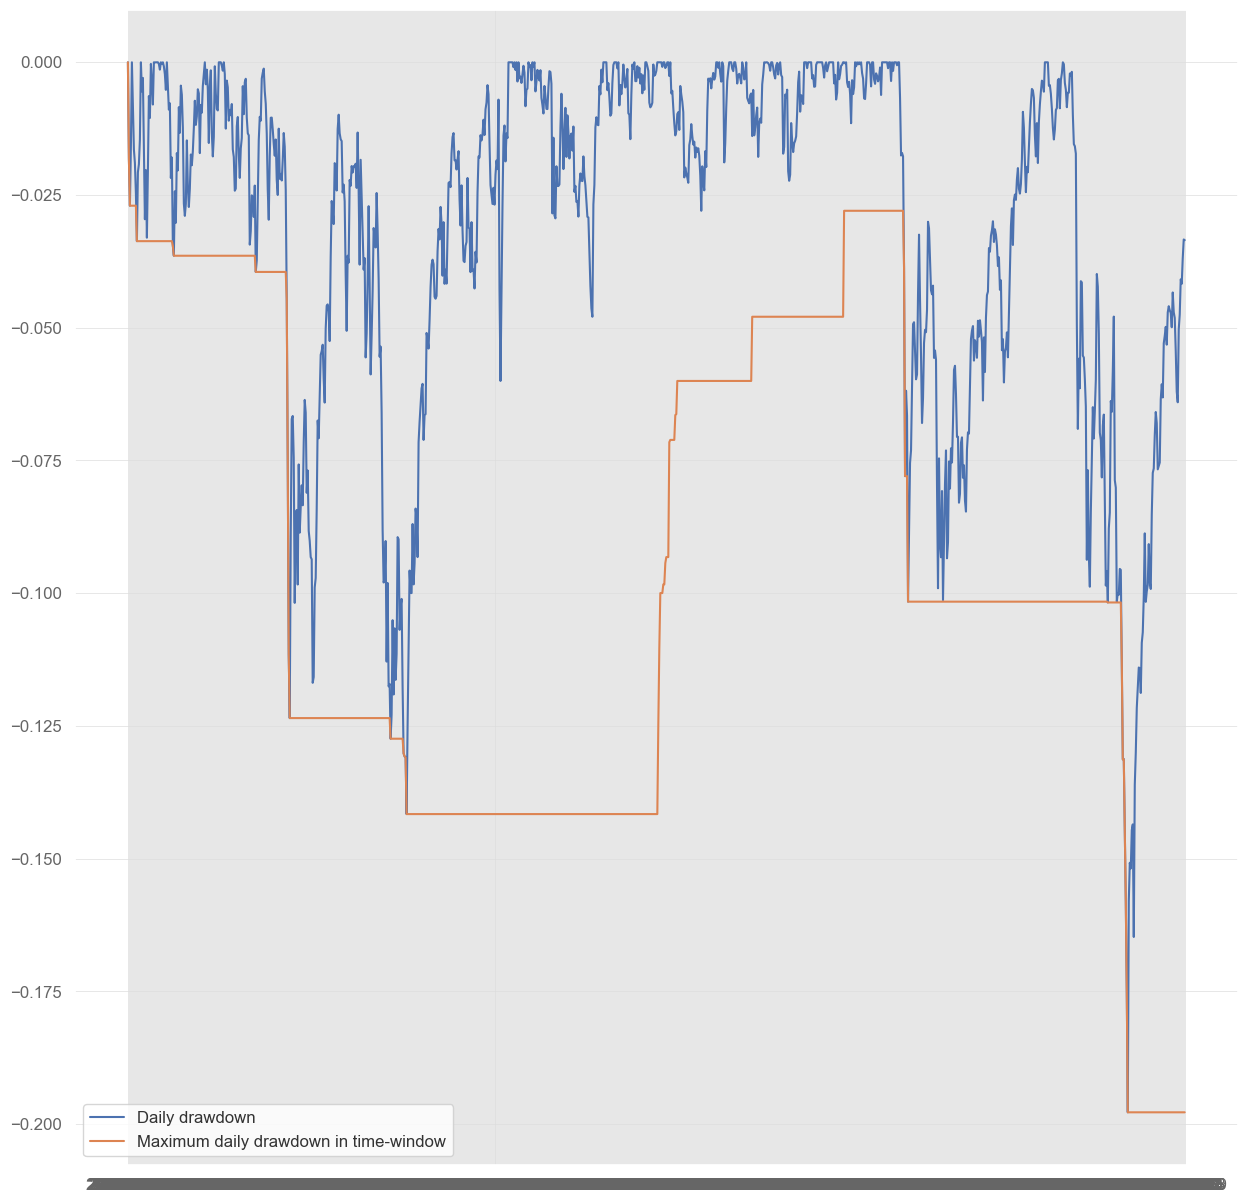

In [39]:
# Plot the results
plt.figure(figsize=(15,15))
plt.plot(sp500['date'], daily_draw_down, label='Daily drawdown')
plt.plot(sp500['date'], max_daily_draw_down, label='Maximum daily drawdown in time-window')
plt.legend()
plt.show()

Active return

In this first exercise, you're going to calculate the active return of a portfolio that's managed against a benchmark. You've learned many ways of how to calculate total return over a period. For this exercise, you'll use the simple mean returns multiplied with the weights to obtain a total return for both the portfolio as well as the benchmark. 

In [40]:
portfolio_data = pd.read_csv('large_pf.csv', index_col=0)
portfolio_data

,mean_return,variance,pf_weights,bm_weights,Security,GICS Sector,GICS Sub Industry
A,0.146146,0.035194,0.000,0.000,Agilent Technologies Inc,Health Care,Health Care Equipment
AAL,0.444411,0.094328,0.214,0.000,American Airlines Group,Industrials,Airlines
AAP,0.242189,0.029633,0.000,0.000,Advance Auto Parts,Consumer Discretionary,Automotive Retail
AAPL,0.225074,0.027283,0.000,0.000,Apple Inc.,Information Technology,Computer Hardware
ABBV,0.182541,0.029926,0.000,0.000,AbbVie,Health Care,Pharmaceuticals
...,...,...,...,...,...,...,...
YHOO,0.162994,0.036719,0.000,0.000,Yahoo Inc.,Information Technology,Internet Software & Services
YUM,0.162098,0.023774,0.000,0.000,Yum! Brands Inc,Consumer Discretionary,Restaurants
ZBH,0.103081,0.020171,0.000,0.000,Zimmer Biomet Holdings,Health Care,Health Care Equipment
ZION,0.225957,0.046199,0.000,0.000,Zions Bancorp,Financials,Regional Banks


In [41]:
# Check the portfolio weights
portfolio_data.pf_weights.sum()

100.0

In [42]:
# Calculate return of the portfolio
total_return_pf = (portfolio_data['pf_weights']*portfolio_data['mean_return']).sum()
total_return_pf

33.134025872593554

In [43]:
# Calculate return of the benchmark
total_return_bm = (portfolio_data['bm_weights']*portfolio_data['mean_return']).sum()
total_return_bm

10.557642112692943

In [44]:
# Calculate and print the active return
active_return = total_return_pf - total_return_bm
print ("%.2f%%" % active_return)

22.58%


Industry attribution

In this exercise, you're going to calculate the relative industry position of your portfolio, versus a benchmark. As a portfolio manager you need to understand your portfolio's underweight and overweight positions (or "industry bets"), as they are a large driver of performance, as well as a potential source of risk.

In [45]:
# Print the sum of the bm and pf weights
print (portfolio_data.bm_weights.sum())
print (portfolio_data.pf_weights.sum())

100.001
100.0


In [46]:
# Group dataframe by GICS sectors 
grouped_df=portfolio_data.groupby('GICS Sector').sum()
grouped_df

,mean_return,variance,pf_weights,bm_weights,Security,GICS Sub Industry
GICS Sector,,,,,,
Consumer Discretionary,14.091950,3.011996,32.426,12.169,Advance Auto PartsAmazon.com IncAutoNation Inc...,Automotive RetailInternet & Direct Marketing R...
Consumer Staples,5.131286,0.639845,24.551,29.727,Archer-Daniels-Midland CoConAgra Foods Inc.Chu...,Agricultural ProductsPackaged Foods & MeatsHou...
Energy,3.390600,1.897641,0.000,0.000,Apache CorporationAnadarko Petroleum CorpBaker...,Oil & Gas Exploration & ProductionOil & Gas Ex...
Financials,8.701437,1.879873,0.000,2.116,"AFLAC IncAmerican International Group, Inc.Ass...",Life & Health InsuranceProperty & Casualty Ins...
Health Care,10.747583,2.349866,11.964,9.099,Agilent Technologies IncAbbVieAmerisourceBerge...,Health Care EquipmentPharmaceuticalsHealth Car...
Industrials,11.336994,2.240226,14.142,11.677,American Airlines GroupAlaska Air Group IncAll...,AirlinesAirlinesBuilding ProductsElectrical Co...
Information Technology,11.217113,2.651298,14.903,6.210,Apple Inc.Accenture plcAdobe Systems IncAnalog...,Computer HardwareIT Consulting & Other Service...
Materials,3.033814,0.877748,0.000,2.043,Albemarle CorpAir Products & Chemicals IncAver...,Specialty ChemicalsIndustrial GasesPaper Packa...
Real Estate,3.959113,0.728886,2.014,0.000,Apartment Investment & MgmtAmerican Tower Corp...,REITsSpecialized REITsResidential REITsREITsRe...


In [47]:
# Calculate active weights of portfolio
grouped_df['active_weight']=grouped_df['pf_weights']-grouped_df['bm_weights']
grouped_df

# You can quickly see from the negative and positive values of the active weights whether the portfolio was over- or underweight a certain sector.

,mean_return,variance,pf_weights,bm_weights,Security,GICS Sub Industry,active_weight
GICS Sector,,,,,,,
Consumer Discretionary,14.091950,3.011996,32.426,12.169,Advance Auto PartsAmazon.com IncAutoNation Inc...,Automotive RetailInternet & Direct Marketing R...,20.257
Consumer Staples,5.131286,0.639845,24.551,29.727,Archer-Daniels-Midland CoConAgra Foods Inc.Chu...,Agricultural ProductsPackaged Foods & MeatsHou...,-5.176
Energy,3.390600,1.897641,0.000,0.000,Apache CorporationAnadarko Petroleum CorpBaker...,Oil & Gas Exploration & ProductionOil & Gas Ex...,0.000
Financials,8.701437,1.879873,0.000,2.116,"AFLAC IncAmerican International Group, Inc.Ass...",Life & Health InsuranceProperty & Casualty Ins...,-2.116
Health Care,10.747583,2.349866,11.964,9.099,Agilent Technologies IncAbbVieAmerisourceBerge...,Health Care EquipmentPharmaceuticalsHealth Car...,2.865
Industrials,11.336994,2.240226,14.142,11.677,American Airlines GroupAlaska Air Group IncAll...,AirlinesAirlinesBuilding ProductsElectrical Co...,2.465
Information Technology,11.217113,2.651298,14.903,6.210,Apple Inc.Accenture plcAdobe Systems IncAnalog...,Computer HardwareIT Consulting & Other Service...,8.693
Materials,3.033814,0.877748,0.000,2.043,Albemarle CorpAir Products & Chemicals IncAver...,Specialty ChemicalsIndustrial GasesPaper Packa...,-2.043
Real Estate,3.959113,0.728886,2.014,0.000,Apartment Investment & MgmtAmerican Tower Corp...,REITsSpecialized REITsResidential REITsREITsRe...,2.014


Momentum factor

In this exercise, you are going to investigate the correlation of the S&P500 returns with 2 factors, momentum and value.

A stock is showing "momentum" if its prior 12-month average of returns is positive. The momentum factor is therefore formed by combining stocks that show consistent positive historic returns. 

The value factor looks at stocks that are inexpensive relative to some measure of fundamental value. For example price-to-earnings and price-to-book are typically ratios to measure "value". 

Let's see how our S&P500 returns relate to the returns of these factors.

In [48]:
# Generate dates
dates = pd.date_range(start='2015-01-02', periods=1059, freq='B')

# Generate random sp500 values
np.random.seed(42)  # For reproducibility
sp500_values = np.random.randn(1059)

# Introduce some NaN values in sp500
sp500_values[0] = np.nan

# Create momentum values with correlation to sp500
momentum_values = sp500_values * 0.5 + np.random.normal(0, 0.5, 1059)

# Generate random value values
value_values = np.random.randn(1059)

# Create the DataFrame
df = pd.DataFrame({
    'sp500': sp500_values,
    'momentum': momentum_values,
    'value': value_values
}, index=dates)

df


,sp500,momentum,value
2015-01-02,NaN,NaN,-2.562334
2015-01-05,-0.138264,0.316717,-0.191028
2015-01-06,0.647689,-1.100427,2.412615
2015-01-07,1.523030,1.335898,0.784604
2015-01-08,-0.234153,-0.986934,-0.019260
...,...,...,...
2019-01-17,-0.550305,-0.776246,-1.317132
2019-01-18,-0.671623,0.034600,0.776028
2019-01-21,-0.025554,-0.269384,-1.002217
2019-01-22,1.172729,0.472065,-0.752435


In [49]:
# Calculate 20-day rolling correlation with momentum 
df['correlation_mom']=df['sp500'].rolling(20).corr(df['momentum'])
# Calculate 20-day rolling correlation with value
df['correlation_value']=df['sp500'].rolling(20).corr(df['value'])

df

,sp500,momentum,value,correlation_mom,correlation_value
2015-01-02,NaN,NaN,-2.562334,NaN,NaN
2015-01-05,-0.138264,0.316717,-0.191028,NaN,NaN
2015-01-06,0.647689,-1.100427,2.412615,NaN,NaN
2015-01-07,1.523030,1.335898,0.784604,NaN,NaN
2015-01-08,-0.234153,-0.986934,-0.019260,NaN,NaN
...,...,...,...,...,...
2019-01-17,-0.550305,-0.776246,-1.317132,0.761447,0.528329
2019-01-18,-0.671623,0.034600,0.776028,0.716432,0.443587
2019-01-21,-0.025554,-0.269384,-1.002217,0.694821,0.417432
2019-01-22,1.172729,0.472065,-0.752435,0.707336,0.281149


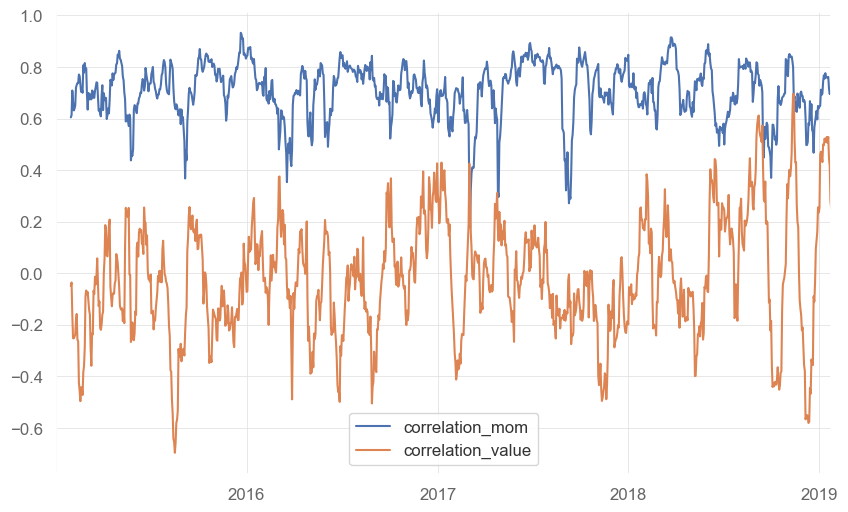

In [50]:
# Plot the correlations (we used random values)
df['correlation_mom'].plot()
df['correlation_value'].plot()
plt.legend()
plt.show()

In [51]:
pd.read_csv('pf_factors.csv')

,date,S&P500,WML,value_factor,portfolio
0,2016-01-04,-1.530373,-1.69,-1.53,-1.651745
1,2016-01-05,0.201223,0.38,0.10,0.408161
2,2016-01-06,-1.311540,1.27,-1.22,0.325555
3,2016-01-07,-2.370044,0.21,-2.38,-0.698259
4,2016-01-08,-1.083837,-0.20,-0.91,-0.959352
...,...,...,...,...,...
247,2016-12-23,0.125172,-0.35,0.07,0.438153
248,2016-12-27,0.224837,0.14,0.27,0.430411
249,2016-12-28,-0.835653,0.08,-0.69,-0.903525
250,2016-12-29,-0.029330,0.02,0.00,0.235954


Fama French factor correlations

In this exercise you want to check how much correlation your portfolio returns have with the Fama French factors. With a quick correlation table, you can very easily gain insight into how your portfolio returns move with for example the excess market return or the size and value factors. Remember, the Fama French factor model was defined as follows:

Rpf = alpha + beta1*Mkt-RF + beta2*SMB + beta3*HML

In [52]:
factor_returns = pd.read_csv('factors_pf_returns.csv', index_col=0)
factor_returns

,Mkt-RF,SMB,HML,RF,pf_returns
date,,,,,
2016-01-04,-1.59,-0.83,0.53,0.000,-1.651745
2016-01-05,0.12,-0.22,0.01,0.000,0.408161
2016-01-06,-1.35,-0.12,0.00,0.000,0.325555
2016-01-07,-2.44,-0.29,0.08,0.000,-0.698259
2016-01-08,-1.11,-0.47,-0.03,0.000,-0.959352
...,...,...,...,...,...
2016-12-23,0.19,0.56,-0.52,0.001,0.438153
2016-12-27,0.27,0.21,0.13,0.001,0.430411
2016-12-28,-0.87,-0.27,0.08,0.001,-0.903525


In [53]:
# Print the correlation table 
factor_returns.corr()

,Mkt-RF,SMB,HML,RF,pf_returns
Mkt-RF,1.000000,0.331250,0.099800,0.087073,0.738586
SMB,0.331250,1.000000,-0.108081,0.076750,0.162303
HML,0.099800,-0.108081,1.000000,-0.049019,-0.237647
RF,0.087073,0.076750,-0.049019,1.000000,0.039383
pf_returns,0.738586,0.162303,-0.237647,0.039383,1.000000


Linear regression model

In this exercise you're going to use the Fama French model to explain the returns in your portfolio. You'll first walk through the linear regression model taking all the different steps, and obtain the summary at the end to interpret the results.

In this exercise you'll use statsmodels. You might have come across the linear regression model in scikit-learn. 

In [54]:
# Define the model
model = sm.OLS(factor_returns['pf_returns'], factor_returns[['Mkt-RF','SMB', 'HML']]).fit()
model

In [55]:
# Create model predictions
predictions = model.predict(factor_returns[['Mkt-RF','SMB', 'HML']]) 
predictions

date
2016-01-04   -1.376476
2016-01-05    0.143971
2016-01-06   -1.084384
2016-01-07   -1.981920
2016-01-08   -0.792760
                ...   
2016-12-23    0.280174
2016-12-27    0.111880
2016-12-28   -0.693659
2016-12-29    0.087132
2016-12-30   -0.499718
Length: 252, dtype: float64

In [56]:
# Print out the summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             pf_returns   R-squared (uncentered):                   0.657
Model:                            OLS   Adj. R-squared (uncentered):              0.653
Method:                 Least Squares   F-statistic:                              158.8
Date:                Tue, 04 Feb 2025   Prob (F-statistic):                    1.55e-57
Time:                        07:40:27   Log-Likelihood:                         -185.67
No. Observations:                 252   AIC:                                      377.3
Df Residuals:                     249   BIC:                                      387.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         0.8234      0.040     20.627      0.000       0.745       0.902
SMB           -0.2272      0.064     -3.545      0.000      -0.353      -0.101
HML           -0.4826      0.056     -8.611      0.000      -0.593      -0.372
==============================================================================
Omnibus:                      143.224   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1746.552
Skew:                           1.972   Prob(JB):                         0.00
Kurtosis:                      15.279   Cond. No.                         1.89
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Fama French Factor model

In this exercise, you are going focus on efficiently obtaining just the beta coefficients of the Fama French model. As you've seen in the video, those betas indicate how much of the portfolio's return changes if that particular factor's return changes.

Sometimes, all you want to do is to check whether the factor relates negatively, or positively to you portfolio returns. You can see this directly from the signs of the coefficients. 

In [57]:
# Obtain the beta coefficients
b1, b2, b3 = sm.OLS(factor_returns['pf_returns'], factor_returns[['Mkt-RF','SMB', 'HML']]).fit().params

# Print the betas
print ('Sensitivities of active returns to factors:\nMkt-Rf: %f\nSMB: %f\nHML: %f' %  (b1, b2, b3))

Sensitivities of active returns to factors:
Mkt-Rf: 0.823443
SMB: -0.227198
HML: -0.482598


Performance tear sheet

In this exercise, you're going to create a full performance tear sheet on the S&P500 returns. You'll see that the elaborate calculations you've done in previous chapters, can very quickly be generated with this simple tear sheet, and by inputting just the returns data. In that sense, this tear sheet can save you a lot of time!

In the first few steps, you'll have to make sure that the data is in the right format otherwise, Pyfolio will give an error. 

In [58]:
sp500

,date,S&P500,Returns
0,2015-01-02,2058.199951,NaN
1,2015-01-05,2020.579956,-0.018278
2,2015-01-06,2002.609985,-0.008893
3,2015-01-07,2025.900024,0.011630
4,2015-01-08,2062.139893,0.017888
...,...,...,...
1054,2019-03-13,2810.919922,0.006950
1055,2019-03-14,2808.479980,-0.000868
1056,2019-03-15,2822.479980,0.004985
1057,2019-03-18,2832.939941,0.003706


In [59]:
# Set the index to datetime
sp500.index = pd.to_datetime(sp500.date)
sp500

,date,S&P500,Returns
date,,,
2015-01-02,2015-01-02,2058.199951,NaN
2015-01-05,2015-01-05,2020.579956,-0.018278
2015-01-06,2015-01-06,2002.609985,-0.008893
2015-01-07,2015-01-07,2025.900024,0.011630
2015-01-08,2015-01-08,2062.139893,0.017888
...,...,...,...
2019-03-13,2019-03-13,2810.919922,0.006950
2019-03-14,2019-03-14,2808.479980,-0.000868
2019-03-15,2019-03-15,2822.479980,0.004985


In [60]:
# Ensure the returns are a series
# returns = sp500['Returns'].fillna(0)  # Fill NaN values with 0 (or use a method that fits your data)
returns = sp500['Returns'].dropna()  # Drop NaN values

returns

date
2015-01-05   -0.018278
2015-01-06   -0.008893
2015-01-07    0.011630
2015-01-08    0.017888
2015-01-09   -0.008404
                ...   
2019-03-13    0.006950
2019-03-14   -0.000868
2019-03-15    0.004985
2019-03-18    0.003706
2019-03-19   -0.000131
Name: Returns, Length: 1058, dtype: float64

In [61]:
# # Create the returns tear sheet using the quantstats library
# qs.reports.full(returns)

# # Create the returns tear sheet using pyfolio
# pf.create_returns_tear_sheet(returns)

In [62]:
# Calculate performance metrics
cumulative_returns = ep.cum_returns(returns)
annual_returns = ep.annual_return(returns)
sharpe_ratio = ep.sharpe_ratio(returns)
max_drawdown = ep.max_drawdown(returns)

# Print the performance metrics
print(f"Cumulative Returns: {cumulative_returns[-1]}")
print(f"Annual Returns: {annual_returns}")
print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown}")


Cumulative Returns: 0.3762365831481842
Annual Returns: 0.07903281135926687
Sharpe Ratio: 0.6250225471024974
Max Drawdown: -0.1977821042395294


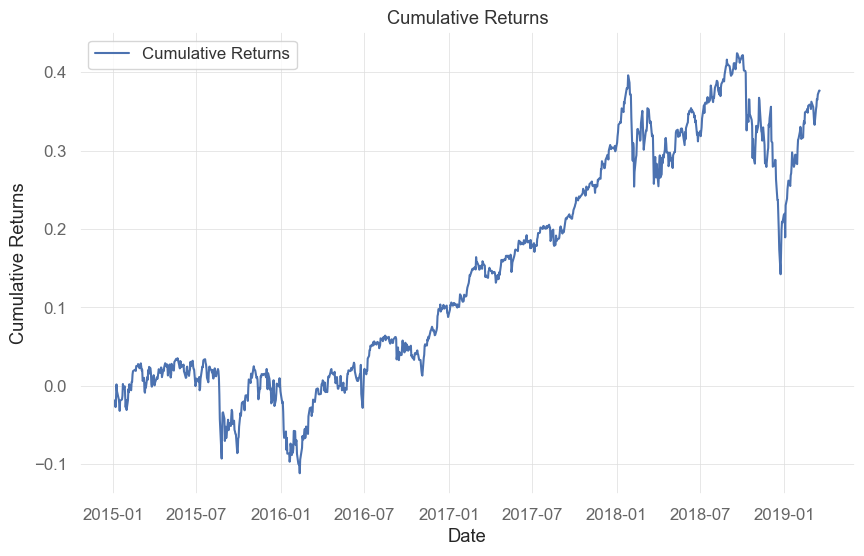

In [63]:
# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Cumulative Returns')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


Industry exposures with Pyfolio

You saw how to use a groupby function to create the active weights per industry. The drawback is that it takes a snapshot in time. Since portfolio weights change, you can imagine that the industry exposures change over time as well. However, the calculation to determine industry exposures on each day for your portfolio can become quite tedious and complex.

Luckily, you can use Pyfolio's tear sheet for this. The tear sheet shows you exposures over time, and summarizes overall top stock picks in your portfolio.

In [64]:
# Generate date range for trading dates
dates = pd.bdate_range(start='2015-01-05', periods=1058)

# Generate random data
np.random.seed(42)  # For reproducibility
data = {
    'AMD': np.random.randn(1058) * 30000,
    'CERN': np.random.randn(1058) * 10000,
    'COST': np.random.randn(1058) * 50000,
    'DELL': np.random.randn(1058) * 20000,
    'GPS': np.random.randn(1058) * 40000,
    'INTC': np.random.randn(1058) * 20000,
    'MMM': np.random.randn(1058) * 10000,
    'cash': np.random.randn(1058) * 20000,
}

# Create DataFrame
positions = pd.DataFrame(data, index=dates)

positions


,AMD,CERN,COST,DELL,GPS,INTC,MMM,cash
2015-01-05,14901.424590,5436.001546,-11429.995767,-20044.340379,-24434.305592,31474.684331,-11694.806292,-7510.000802
2015-01-06,-4147.929035,-3706.143321,-49717.468730,-15048.704747,20179.330255,9133.760215,-7209.701085,13989.284938
2015-01-07,19430.656143,7716.987106,-128116.682940,-29335.703812,-62521.372263,-29923.176263,27799.636242,-37500.147749
2015-01-08,45690.895692,-28485.426206,-9551.388130,-10028.042938,-47178.386580,-18364.243330,-10379.913550,23599.770594
2015-01-09,-7024.601242,11487.657004,120630.771081,19506.249170,57403.495969,26454.889338,-13537.546747,21044.223119
...,...,...,...,...,...,...,...,...
2019-01-17,7820.212975,-1627.929061,-20798.346397,8394.112167,16633.065178,-3301.611300,5740.419309,31790.460722
2019-01-18,-16509.154615,409.191754,-47287.303035,5531.630112,-48675.868414,635.189132,-1098.641231,-15008.202555
2019-01-21,-20148.701038,-10021.874558,30412.309584,171.121616,54535.060542,1513.470812,-1840.868670,-43240.645999
2019-01-22,-766.622130,7408.243454,-65856.595997,-31417.629143,-24206.249424,-8645.903582,-7721.923878,9167.780199


In [65]:
# Generate random data for returns
returns_data = np.random.randn(1058) / 100

# Create returns Series
returns = pd.Series(returns_data, index=dates, name='Returns')

returns


2015-01-05    0.009886
2015-01-06   -0.003811
2015-01-07    0.006037
2015-01-08    0.014015
2015-01-09   -0.012089
                ...   
2019-01-17    0.011905
2019-01-18   -0.002007
2019-01-21   -0.004047
2019-01-22    0.010296
2019-01-23    0.019825
Freq: B, Name: Returns, Length: 1058, dtype: float64

In [66]:
# Define sector mappings
sect_map = {'COST': 'Consumer Goods',
            'INTC': 'Technology', 
            'CERN': 'Healthcare', 
            'GPS': 'Technology',
            'MMM': 'Construction', 
            'DELL': 'Technology', 
            'AMD': 'Technology'}

Top 10 long positions of all time,max
AMD,52603.69%
MMM,27894.52%
GPS,19132.42%
DELL,16996.27%
COST,12671.94%
INTC,3456.67%
CERN,2125.58%


Top 10 short positions of all time,max
INTC,-69713.31%
COST,-35162.62%
AMD,-34551.85%
CERN,-30598.13%
MMM,-11067.71%
DELL,-5309.87%
GPS,-4776.37%


Top 10 positions of all time,max
INTC,69713.31%
AMD,52603.69%
COST,35162.62%
CERN,30598.13%
MMM,27894.52%
GPS,19132.42%
DELL,16996.27%


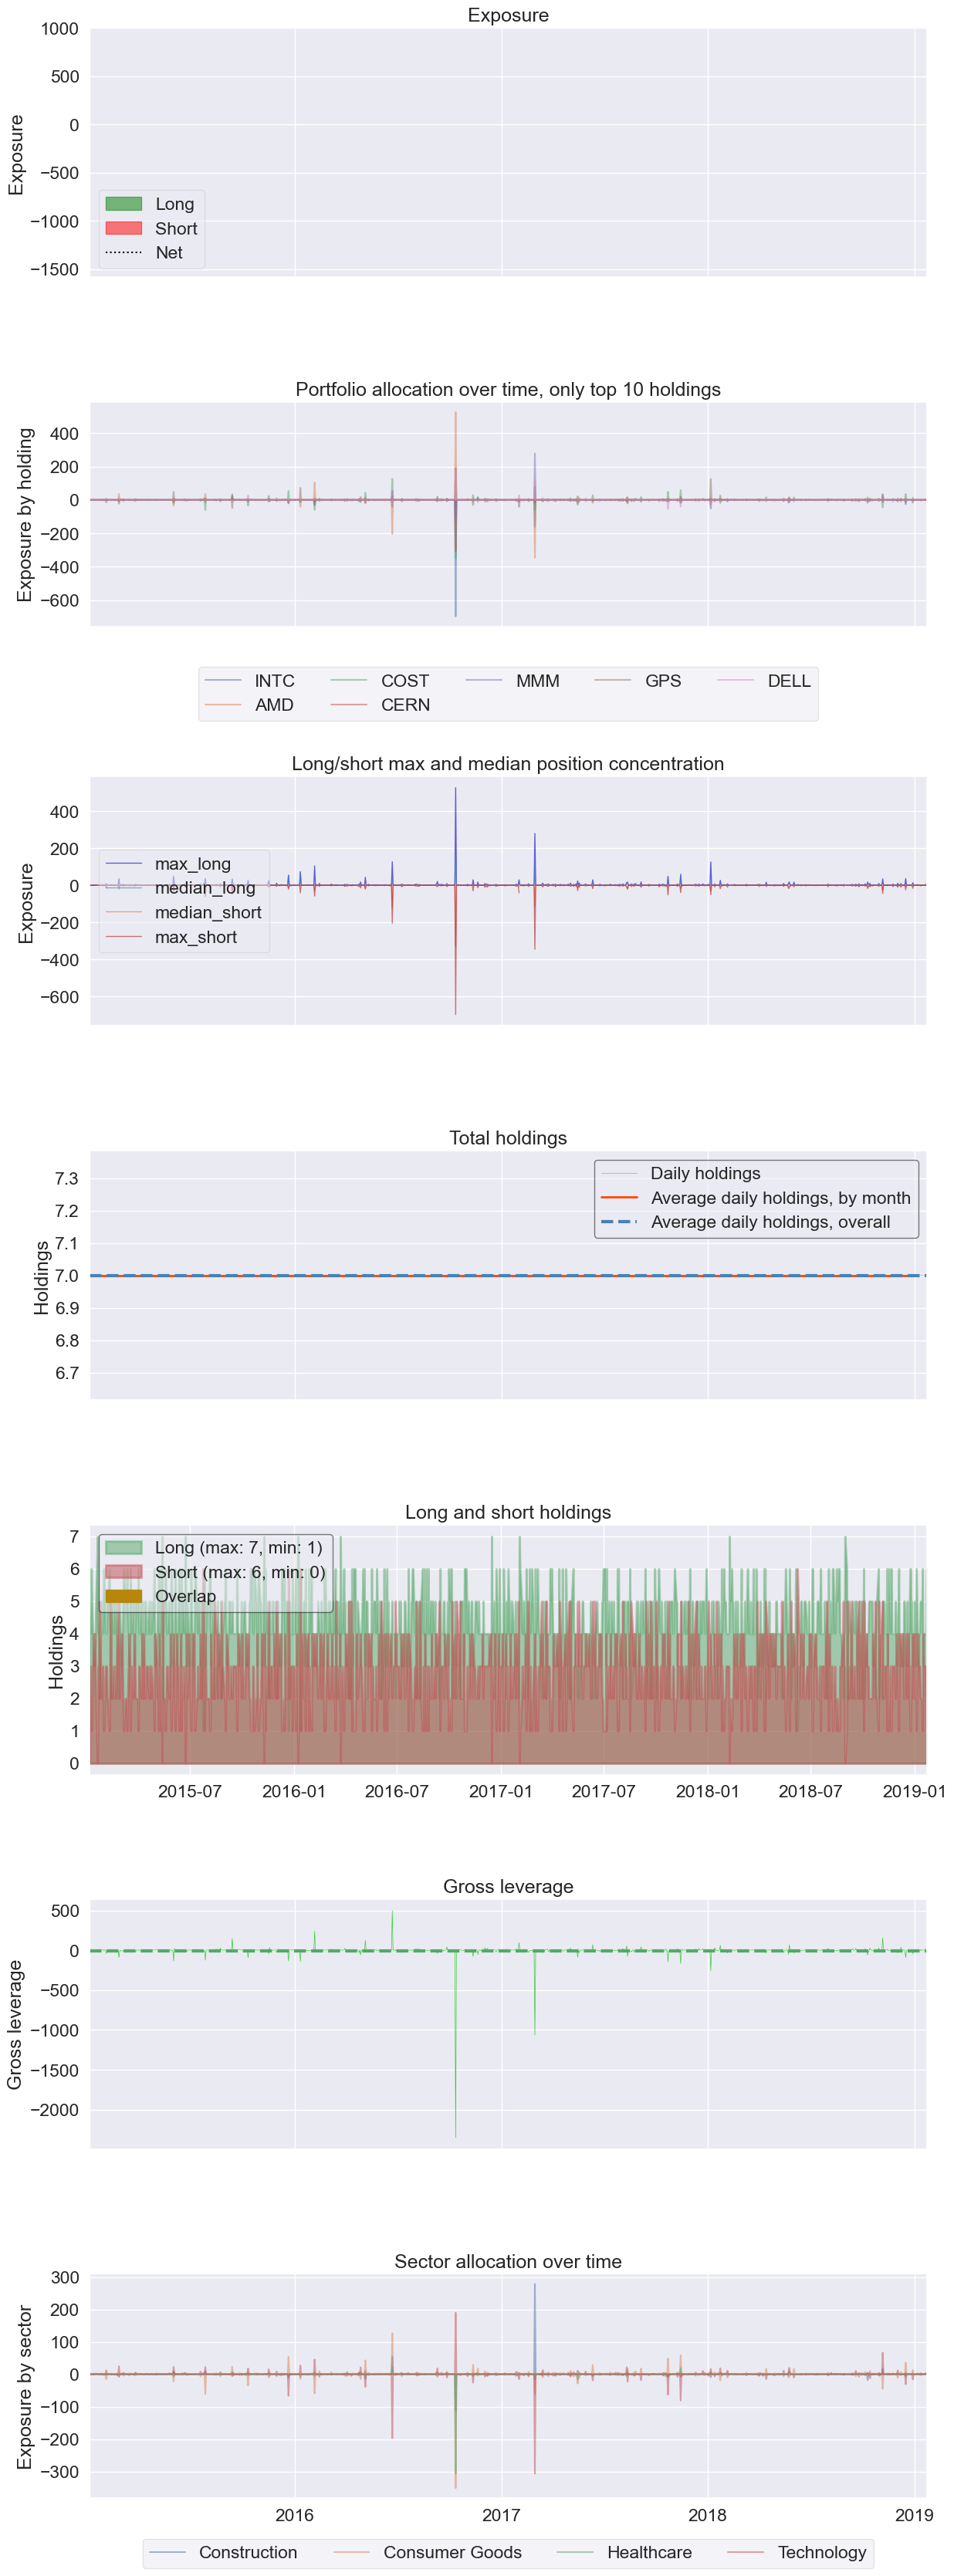

In [67]:
# Create sector exposure tear sheet
pf.create_position_tear_sheet(returns, positions, sector_mappings=sect_map)

Calculating expected risk and returns

For this exercise, you're going to start with the raw price data. What you'll need for portfolio optimization, is the expected risk and return from this data.

With PyPortfolioOpt, you can calculate the expected risk and return in just one line of code, so that makes it very easy for you. The library you need is called pypfopt in short. FYI, you'll see in the next exercise that PyPortfolioOpt gives you the same output if you were to calculate it by hand. 

In [68]:
small_portfolio

,GE,JPM,MSFT,PG
date,,,,
2015-01-02,25.06,62.49,46.760,90.44
2015-01-05,24.60,60.55,46.325,90.01
2015-01-06,24.07,58.98,45.650,89.60
2015-01-07,24.08,59.07,46.230,90.07
2015-01-08,24.37,60.39,47.590,91.10
...,...,...,...,...
2018-03-21,13.88,114.74,92.480,77.04
2018-03-22,13.35,109.95,89.790,76.41
2018-03-23,13.07,107.01,87.180,75.91


In [69]:
# Calculate expected returns mu 
mu = expected_returns.mean_historical_return(small_portfolio)
mu

GE     -0.175812
JPM     0.185643
MSFT    0.223083
PG     -0.045684
dtype: float64

In [70]:
# Calculate the covariance matrix S
Sigma = risk_models.sample_cov(small_portfolio)
Sigma

,GE,JPM,MSFT,PG
GE,0.046355,0.023011,0.016415,0.010182
JPM,0.023011,0.047033,0.024328,0.010899
MSFT,0.016415,0.024328,0.054486,0.014257
PG,0.010182,0.010899,0.014257,0.020810


In [71]:
# Obtain the efficient frontier
ef = EfficientFrontier(mu, Sigma)
ef

# Now that you have calculated the efficient frontier with your given measures of expected risk and return, 
# you can select an optimal portfolio from that frontier, that fits your risk and return appetite. 
# That might be the portfolio with the Maximum Sharpe ratio, or even the portfolio with the lowest level of risk.

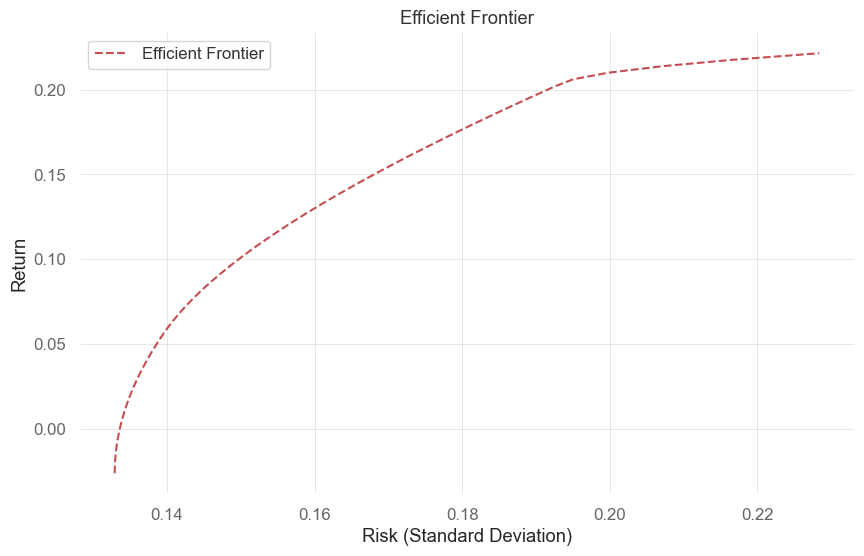

In [72]:

# Obtain the mean and standard deviation of expected returns
mean_return = mu.mean()
std_return = mu.std()

# Generate a range of target returns within the feasible range
target_returns = np.linspace(mean_return - std_return, mean_return + std_return, 100)

ef_risks = []
ef_returns = []

# Iterate over the target returns to calculate risk for each
for ret in target_returns:
    ef = EfficientFrontier(mu, Sigma)  # Create a new instance for each iteration
    try:
        ef.efficient_return(target_return=ret)
        perf = ef.portfolio_performance()
        ef_risks.append(perf[1])
        ef_returns.append(perf[0])
    except ValueError as e:
        # Skip values that cause errors
        continue

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(ef_risks, ef_returns, 'r--', label='Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.show()


PyPortfolioOpt risk functions

The objective of the Markowitz portfolio optimization problem is to minimize the portfolio variance, given a bunch of constraints. Do you remember how you calculate this from chapter 2? Portfolio variance = weights transposed * covariance matrix * weights. WithPyPortfolioOpt we call the covariance matrix sigma, to denote that this is a sample covariance.

In this exercise you will see that thePyPortfolioOpt functions to calculate sigma, gives the exact same result if you were to calculate the covariance by hand. The same goes for the expected return calculations, you can also verifyPyPortfolioOpt gives the same output as calculating annualized daily returns by hand.

In [73]:
# Get the returns from the stock price data
returns=small_portfolio.pct_change()
returns

,GE,JPM,MSFT,PG
date,,,,
2015-01-02,NaN,NaN,NaN,NaN
2015-01-05,-0.018356,-0.031045,-0.009303,-0.004755
2015-01-06,-0.021545,-0.025929,-0.014571,-0.004555
2015-01-07,0.000415,0.001526,0.012705,0.005246
2015-01-08,0.012043,0.022346,0.029418,0.011436
...,...,...,...,...
2018-03-21,0.017595,0.000872,-0.006979,-0.016218
2018-03-22,-0.038184,-0.041747,-0.029087,-0.008178
2018-03-23,-0.020974,-0.026739,-0.029068,-0.006544


In [74]:
# Calculate the annualized covariance matrix 
covMatrix = returns.cov()*252
covMatrix

,GE,JPM,MSFT,PG
GE,0.046355,0.023011,0.016415,0.010182
JPM,0.023011,0.047033,0.024328,0.010899
MSFT,0.016415,0.024328,0.054486,0.014257
PG,0.010182,0.010899,0.014257,0.020810


Optimal portfolio performance

Let's now continue with the efficient frontier ef that you calculated in a previous exercise for the small portfolio. You still need to select an optimal portfolio from that efficient frontier ef, and check its performance. Let's use the efficient_return option. This function selects the portfolio with the minimized risk given a target return. A portfolio manager is often asked to manage a portfolio under certain risk and return constraints, so this is a very useful function for that.

In [75]:
# Get the minimum risk portfolio for a target return of 20%
weights = ef.efficient_return(0.2)
weights

OrderedDict([('GE', 0.0),
             ('JPM', 0.4926529085352374),
             ('MSFT', 0.4900890447252645),
             ('PG', 0.0172580467394981)])

In [76]:
# Show portfolio performance 
ef.portfolio_performance(verbose=True)

Expected annual return: 20.0%
Annual volatility: 19.2%
Sharpe Ratio: 1.04


(0.2, 0.19152666984849026, 1.0442409934773715)

Portfolio optimization: Max Sharpe

In this exercise, you're going to calculate the portfolio that gives the Maximum Sharpe ratio. Often, this is the portfolio the investor wants to invest in, as it provides the highest possible return to risk ratio.

PyPortfolioOpt makes it very easy to calculate this portfolio from a set of historical price data.

In [81]:
# Define the efficient frontier (new instance creation necessary)
ef = EfficientFrontier(mu, Sigma)

In [82]:
# Calculate weights for the maximum Sharpe ratio portfolio
raw_weights_maxsharpe = ef.max_sharpe()
raw_weights_maxsharpe

# Looking closely at some of the stocks in the portfolio, two have negative historic performance, and by adding them they don't actually lower the risk of the portfolio. 
# That means that when we optimize for risk and return, apparently it is optimal not to invest in those.

OrderedDict([('GE', 0.0),
             ('JPM', 0.4396007898087102),
             ('MSFT', 0.5603992101912898),
             ('PG', 0.0)])

In [83]:
cleaned_weights_maxsharpe = ef.clean_weights()
cleaned_weights_maxsharpe

OrderedDict([('GE', 0.0), ('JPM', 0.4396), ('MSFT', 0.5604), ('PG', 0.0)])

Minimum volatility 

In this exercise, you're going to compare the minimum volatility and the Maximum Sharpe portfolios. As a portfolio manager you often want to understand how your chosen portfolio measures up to the minimum volatility portfolio. WithPyPortfolioOpt you can compare the two quickly, without having to write two different constrained optimization problems, which can be quite complex.

In [85]:
# Show maximum Sharpe ratio portfolio performance 
ef.portfolio_performance(verbose=True)

Expected annual return: 20.7%
Annual volatility: 19.5%
Sharpe Ratio: 1.06


(0.2066246894935924, 0.19541429308534639, 1.0573673308704696)

In [87]:
# Define the efficient frontier (new instance creation necessary)
ef = EfficientFrontier(mu, Sigma)

In [88]:
# Calculate weights for the minimum volatility portfolio
raw_weights_minvol = ef.min_volatility()
cleaned_weights_minvol = ef.clean_weights()

# Show portfolio performance
print(cleaned_weights_minvol)

OrderedDict([('GE', 0.15732), ('JPM', 0.11714), ('MSFT', 0.04704), ('PG', 0.6785)])


In [89]:
# Show minimum volatility portfolio performance 
ef.portfolio_performance(verbose=True)

Expected annual return: -2.6%
Annual volatility: 13.3%
Sharpe Ratio: -0.20


(-0.026415861751657235, 0.1329238660783018, -0.19872926157667106)

Exponentially weighted returns and risk

In this exercise, you're going to perform portfolio optimization with a slightly different way of estimating risk and returns; you're going to give more weight to recent data in the optimization.

This is a smart way to deal with stock data that is typically non-stationary, i.e., when the distribution changes over time. Implementation can be quickly done by changing the risk model you use to calculate Sigma, and the returns calculation you use to get mu. 

In [91]:
# Define exponentially weightedSigma and mu using stock_prices
Sigma = risk_models.exp_cov(small_portfolio, span=180, frequency=252)
Sigma

,GE,JPM,MSFT,PG
GE,0.089302,0.026028,0.013672,0.009110
JPM,0.026028,0.045717,0.034885,0.009699
MSFT,0.013672,0.034885,0.067528,0.009651
PG,0.009110,0.009699,0.009651,0.022898


In [93]:
mu = expected_returns.ema_historical_return(small_portfolio, frequency=252, span=180)
mu

GE     -0.593308
JPM     0.172294
MSFT    0.285390
PG     -0.241595
Name: 2018-03-27, dtype: float64

In [94]:
# Calculate the efficient frontier
ef = EfficientFrontier(mu, Sigma)
ef

In [95]:
# Calculate weights for the maximum sharpe ratio optimization
raw_weights_maxsharpe = ef.max_sharpe()
raw_weights_maxsharpe

OrderedDict([('GE', 0.0),
             ('JPM', 0.1926271296313854),
             ('MSFT', 0.8073728703686145),
             ('PG', 0.0)])

In [96]:
# Show portfolio performance 
ef.portfolio_performance(verbose=True)

# Since the span is relatively long, and the trends are persistent, this means that the more recent data is pretty similar to the full dataset. 
# In that sense, you are not getting a very large gain by using the exponentially weighted approach when your data is predictable and has persistent trends.

Expected annual return: 26.4%
Annual volatility: 23.8%
Sharpe Ratio: 1.11


(0.26360441503021814, 0.23783464413629896, 1.1083516280292243)

Changing the span

At the last exercise you discovered that the span of the exponentially weighted risk and return can have an impact on what the optimal portfolio looks like. In fact, the span has a very big influence! By setting the span, you can either use data for say only the most recent days, or use data from the most recent years. In the limit, when the span is as long as the full sample, it will be equal to using the normal historic mean.

Now let's get a feel for how a short and long span changes your optimal portfolio. 

In [100]:
# Calculate expected returns and sample covariance over a two years span
mu_ema = expected_returns.ema_historical_return(small_portfolio, span=504 ,frequency=252)
Sigma_ew = risk_models.exp_cov(small_portfolio, span=504, frequency=252)
ef_2 = EfficientFrontier(mu_ema, Sigma_ew)
mu_ema, Sigma_ew

(GE     -0.418972
 JPM     0.270234
 MSFT    0.328240
 PG     -0.095537
 Name: 2018-03-27, dtype: float64,
             GE       JPM      MSFT        PG
 GE    0.060420  0.020274  0.010813  0.006804
 JPM   0.020274  0.041050  0.022130  0.007060
 MSFT  0.010813  0.022130  0.048862  0.008796
 PG    0.006804  0.007060  0.008796  0.019559)

In [99]:
# Calculate weights for the maximum Sharpe ratio portfolio
weights = ef_2.max_sharpe()
cleaned_weights_maxsharpe_EW = ef_2.clean_weights()
perf_max_sharpe_EW = ef_2.portfolio_performance(verbose=True)

Expected annual return: 30.3%
Annual volatility: 18.5%
Sharpe Ratio: 1.64


In [102]:
# Calculate expected returns and sample covariance over a ten days span
mu_ema = expected_returns.ema_historical_return(small_portfolio, span=10 ,frequency=252)
Sigma_ew = risk_models.exp_cov(small_portfolio, span=10, frequency=252)
ef_2 = EfficientFrontier(mu_ema, Sigma_ew)
mu_ema, Sigma_ew

(GE     -0.502643
 JPM    -0.817038
 MSFT   -0.700353
 PG      0.128148
 Name: 2018-03-27, dtype: float64,
             GE       JPM      MSFT        PG
 GE    0.186815  0.013536 -0.071615  0.044128
 JPM   0.013536  0.129652  0.193641  0.007712
 MSFT -0.071615  0.193641  0.374924 -0.002884
 PG    0.044128  0.007712 -0.002884  0.029021)

In [103]:
# Calculate weights for the maximum Sharpe ratio portfolio
weights = ef_2.max_sharpe()
cleaned_weights_maxsharpe_EW = ef_2.clean_weights()
perf_max_sharpe_EW = ef_2.portfolio_performance(verbose=True)

# If your data is very volatile and changes rapidly, working with a short span might give you better predictive power of the expected return, with a faster moving investment strategy. 
# However, if your data is rather slow moving as is the case with this data, the short span does not help you in better predicting expected risk and returns

Expected annual return: 12.8%
Annual volatility: 17.0%
Sharpe Ratio: 0.75
